<a href="https://colab.research.google.com/github/wlwlaa/MNISTModel/blob/main/MNISTModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Импортируем необходимые библиотеки
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

torch.__version__

'2.2.1+cu121'

In [2]:
# Настроим аппаратно-независимый код
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#torch.set_default_device(device)
device

'cpu'

## Подготовим данные

Используем MNIST датасет для обучения модели распознавания рукописных цифр

In [3]:
# Загрузим датасет
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
# Выделим необходимые данные
n_train = len(train_data)
n_test = len(test_data)

class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

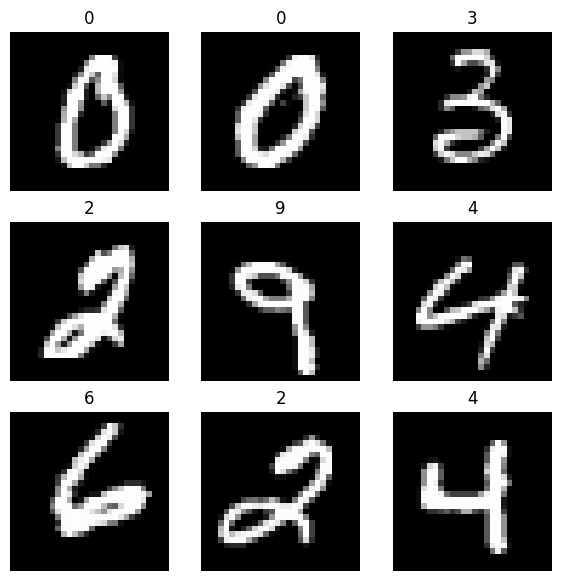

In [5]:
# Визуализируем несколько сэмплов
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(7, 7))
rows, cols = 3, 3

for i in range(1, rows*cols + 1):
  index = torch.randint(0, n_train, size=[1]).item()
  img, label = train_data[index]

  fig.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis(False)
  plt.imshow(img.reshape([28, 28, 1]), cmap='gray');

In [6]:
# Создадим DataLoaders
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size = BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size = BATCH_SIZE,
    shuffle=False
)

## Построим модель

Построим модель на основе структуры TinyVGG

In [7]:
class MNISTModel(nn.Module):
  def __init__(self, input_shape: int = 1, hidden_units: int = 10, output_shape: int = 10):
    super().__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            padding=1,
            stride=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            padding=1,
            stride=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            padding=1,
            stride=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            padding=1,
            stride=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units * 7 * 7,
            out_features=output_shape
        )
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classifier(x)
    return x

model = MNISTModel().to(device)
model

MNISTModel(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [8]:
# Установим завсисмости
try:
  from torchmetrics import Accuracy, ConfusionMatrix
except ModuleNotFoundError:
  !pip install torchmetrics
  from torchmetrics import Accuracy, ConfusionMatrix

In [9]:
# Настроим optimizer, accuracy & loss functions
optimizer = torch.optim.ASGD(
    model.parameters(),
    lr=0.1
)
loss_fn = nn.CrossEntropyLoss()
accuracy = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

In [11]:
# Обучим модель
import time
from tqdm.auto import tqdm

start_time = time.time()

epochs = 5
for epoch in tqdm(range(epochs)):
  print(f'Эпоха: {epoch}\n--------------')

  train_loss = 0
  model.train()
  for X, y in tqdm(train_dataloader):
    X, y = X.to(device), y.to(device)

    train_preds = model(X)

    loss = loss_fn(train_preds, y)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  test_loss, test_accuracy = 0, 0
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_preds = model(X_test)

      test_loss += loss_fn(test_preds, y_test)
      test_accuracy += accuracy(test_preds, y_test)

  print(f'Train loss: {(train_loss / n_train):.4f} | Test loss: {(test_loss / n_test):.4f} | Test accuracy: {(test_accuracy / n_test * 32 * 100):.2f}%')

print(f'Затраченное на обучение на {device} время: {(time.time() - start_time):.4f} секунд')

  0%|          | 0/5 [00:00<?, ?it/s]

Эпоха: 0
--------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.0067 | Test loss: 0.0021 | Test accuracy: 97.95%
Эпоха: 1
--------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.0021 | Test loss: 0.0014 | Test accuracy: 98.66%
Эпоха: 2
--------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.0016 | Test loss: 0.0015 | Test accuracy: 98.60%
Эпоха: 3
--------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.0014 | Test loss: 0.0013 | Test accuracy: 98.74%
Эпоха: 4
--------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.0012 | Test loss: 0.0014 | Test accuracy: 98.69%
Затраченное на обучение на cpu время: 297.8734 секунд


  0%|          | 0/313 [00:00<?, ?it/s]

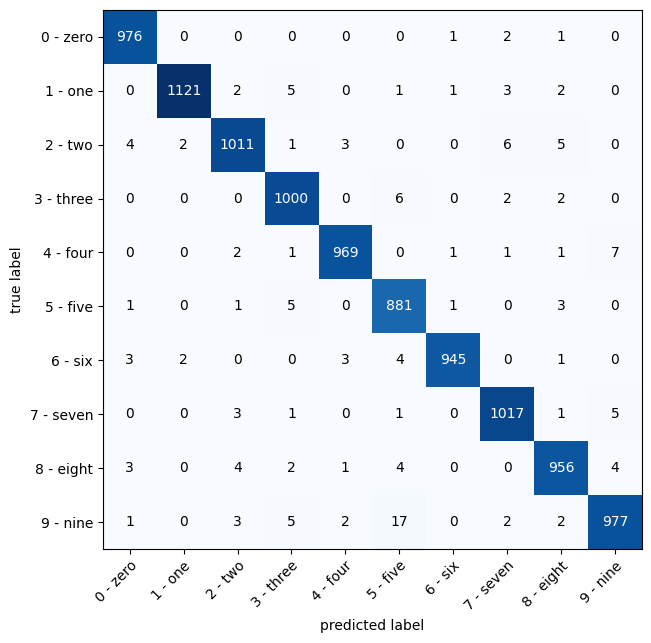

In [12]:
# Сгенерируем матрицу ошибок
from mlxtend.plotting import plot_confusion_matrix
from matplotlib import pyplot as plt

preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    preds.append(model(X.to(device)).squeeze().argmax(dim=1))

preds = torch.cat(preds)

matrix = ConfusionMatrix(
    task='multiclass',
    num_classes=10
).to(device)
matrix_tensor = matrix(preds=preds, target=test_data.targets.to(device))

fig, ax = plot_confusion_matrix(
    conf_mat=matrix_tensor.cpu().numpy(),
    class_names=test_data.classes,
    figsize=(10, 7)
)

In [13]:
print(f'Достигнута точность {accuracy(preds, torch.tensor([test_data[i][1] for i in range(n_test)])).item() * 100}%')

Достигнута точность 98.53000044822693%


Модель была обучена успешно, показана высокая точность на тестовых данных👍

In [14]:
from pathlib import Path

PATH = Path('.')
NAME = 'MNIST_model_tinyVGG_state_dict.pth'
SAVE_PATH = PATH / NAME
torch.save(
    obj=model.state_dict(),
    f=SAVE_PATH
)